## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip, Grayscale
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from helpers import *

In [2]:
# pip install torchsampler
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(102)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [5]:
size = 42
batch_size = 256
transformation = Compose([RandomHorizontalFlip(), Grayscale(1), Resize((size, size)), ToTensor()])

In [6]:
root = 'chest_xray/train'
train_data = create_dataset(root, transformation)
sampler_train = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler_train)

In [7]:
root = 'chest_xray/test'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = 'chest_xray/val'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[3932, 3824, 2696, 806, 1491, 2627, 545, 1881, 1093]


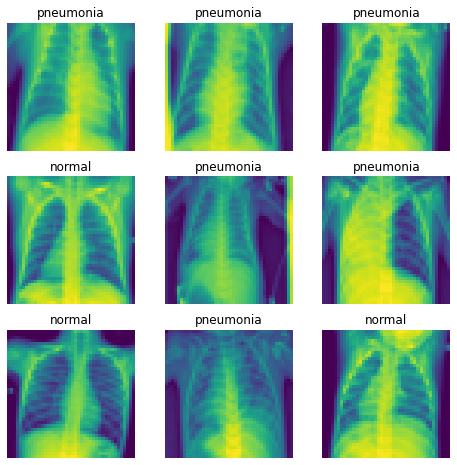

In [9]:
visualize_data(train_data)

[196, 234, 216, 38, 355, 136, 50, 267, 443]


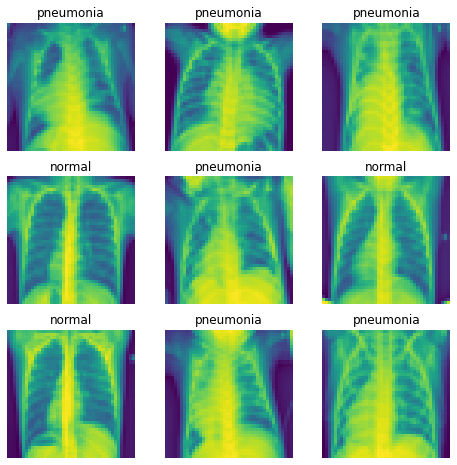

In [10]:
visualize_data(test_data)

## Model Definition

In [11]:
class DeepLearnConv(torch.nn.Module):
    def __init__(self, inputs, outputs, weights, kernel_size):
        super(DeepLearnConv, self).__init__()
        
        self.conv = nn.Conv2d(inputs, outputs, kernel_size = kernel_size)
        with torch.no_grad():
            self.conv.weight = nn.Parameter(weights)
        self.batch_norm = nn.BatchNorm2d(outputs)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = F.leaky_relu(x)
        x = self.dropout(x)
        return x

In [12]:
class DeepLearnLinear(torch.nn.Module):
    def __init__(self, inputs, outputs):
        super(DeepLearnLinear, self).__init__()
        
        self.linear = nn.Linear(inputs, outputs)
        nn.init.xavier_uniform_(self.linear.weight)
        self.batch_norm = nn.BatchNorm1d(outputs)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x

In [13]:
class DeepLearn(torch.nn.Module):
    def __init__(self, kernels, hidden, kernel_size, window, hidden_linear, labels):
        super(DeepLearn, self).__init__()
        
        self.kernels = kernels
        self.conv = [DeepLearnConv(hidden[i], hidden[i+1], 
                                    self.kernels[i].view(1, 1, 3, 3).repeat(hidden[i+1], hidden[i], 1, 1), 
                                    kernel_size) for i in range(len(hidden)-1)]
        self.conv_combined = nn.Sequential(*self.conv)
        
        self.maxpool = nn.MaxPool2d(window)
        self.flattened = hidden_linear[0]
        self.linear= [DeepLearnLinear(hidden_linear[i], hidden_linear[i+1]) for i in range(len(hidden_linear)-1)]
        self.linear_combined = nn.Sequential(*self.linear)
        
        self.output = nn.Linear(hidden_linear[-1], labels)
    
    def forward(self, x):
        x = self.conv_combined(x)
        x = self.maxpool(x)
        x = x.view(-1, self.flattened)
        x = self.linear_combined(x)
        x = self.output(x)
        return x

## Training Model & Hyperparameter Tuning

In [14]:
def create_adam_optimizer(lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [15]:
from math import floor
#sharp sobel kernels
kernels = [torch.tensor([[0., -1., 0.],
                        [-1., 5., -1.],
                        [0., -1., 0.]]),
           torch.tensor([[1., 2., 1.],
                        [0., 0., 0.],
                        [-1., -2., -1.]]),
           torch.tensor([[1., 0., -1.],
                        [2., 0., -2.],
                        [1., 0., -1.]])]

# number of hidden layers and their sizes
hidden = [1, 128, 64, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 4096, 512, 64]
labels = 2

In [16]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [17]:
model = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
optimizer = create_adam_optimizer()
print(model)

DeepLearn(
  (conv_combined): Sequential(
    (0): DeepLearnConv(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepLearnConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepLearnConv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear_combined): Sequential(
    (0): DeepLearnLinear(
      (linear): Linear(in_features=20736, out_features=4096, bias=True)
    

In [22]:
# repeat this cell with epochs = 1 for safety, but usually epochs = 3 is a good start
tl, ta, vl, va = train(device, model, train_loader, val_loader, test_loader, epochs = 1, optimizer = optimizer)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/1, Batch number: 0, Cumulated accuracy: 0.91015625
Epoch 1/1, Batch number: 5, Cumulated accuracy: 0.9270833333333334
Epoch 1/1, Batch number: 10, Cumulated accuracy: 0.9204545454545454
Epoch 1/1, Batch number: 15, Cumulated accuracy: 0.92236328125
--- Epoch 1/1: Train loss: 0.2119, Train accuracy: 0.9225
--- Epoch 1/1: Val loss: 0.2807, Val accuracy: 0.9077


## Testing Model & Performance Curves

In [23]:
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test(device, model, test_loader, criterion, verbose=True)

Test loss: 0.3032, Test accuracy: 0.8598


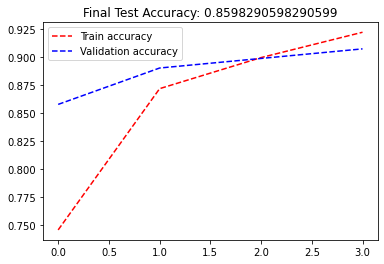

In [24]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

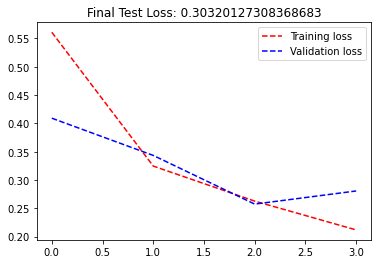

In [25]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Saving Model

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './latest')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest")["model_state_dict"])
test_losses, test_accuracy = test(model_test, test_loader)